# Lab 5: Wide and Deep Networks

#### Prepartion

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Read the data
data = 'healthcare-dataset-stroke-data.csv'
df = pd.read_csv(data)
print(df.shape)
df.head()

(5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [2]:
# drop id column
df = df.drop(['id'], axis=1)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


The data is organized as follows:

|Variable | Description|
|---------|------------|
|gender| Male/Female|
|age| continuous|
|hypertension| 0=No, 1=Yes|
|heart_disease| 0=No, 1=Yes|
|ever_married| No/Yes|
|work_type| children, Govt_jov, Never_worked, Private, Self-employed|
|Residence_type| Rural/Urban|
|avg_glucose_level| continuous|
|bmi| continuous|
|smoking_status| formerly smoked, never smoked, smokes, Unknown|
|`stroke`| 0=No, 1=Yes|

In [4]:
# check for missing values and drop them
print(df.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


We need to decide if we want to drop all the rows with unknown smoking status or if we want to impute them. We will drop them for now.

In [5]:
df.dropna(inplace=True)
print(df.shape)
print(df.isnull().sum())

(4909, 11)
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


In [6]:
# check for duplicates
df.duplicated().sum()

0

In [7]:
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.13.0


In [8]:
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.layers import Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [9]:
# create a tensorflow dataset
batch_size = 64

def df_to_dataset(df, shuffle=True, batch_size=batch_size):
    df = df.copy()
    labels = df.pop('stroke')
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size)
    return ds

ds = df_to_dataset(df)

2023-11-06 17:15:58.673283: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-06 17:15:58.673306: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-06 17:15:58.673311: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-06 17:15:58.673349: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-06 17:15:58.673367: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
# print out the data type of each feature
for feature_batch, label_batch in ds.take(1):
    print('Every feature:', list(feature_batch.keys()))
    # print feature datatype
    print('Feature shape for age is:', feature_batch['age'].shape)
    print('Max:', max(feature_batch['age']))

Every feature: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']
Feature shape for age is: (64,)
Max: tf.Tensor(82.0, shape=(), dtype=float64)


priotize false negatives for stroke screenings before seeing a doctor.

In [12]:
from tensorflow.keras.utils import FeatureSpace

feature_space = FeatureSpace(
    features={

        # Categorical features encoded as string
        'gender': FeatureSpace.string_categorical(num_oov_indices=0),
        'ever_married': FeatureSpace.string_categorical(num_oov_indices=0),
        'work_type': FeatureSpace.string_categorical(num_oov_indices=0),
        'Residence_type': FeatureSpace.string_categorical(num_oov_indices=0),
        'smoking_status': FeatureSpace.string_categorical(num_oov_indices=0),

        # Numerical features
        'age': FeatureSpace.float_discretized(num_bins=10),

        # Numerical features to normalize
        'avg_glucose_level': FeatureSpace.float_normalized(),
        'bmi': FeatureSpace.float_normalized(),

        # Categorical features encoded as integers
        'hypertension': FeatureSpace.integer_categorical(num_oov_indices=0),
        'heart_disease': FeatureSpace.integer_categorical(num_oov_indices=0),
    },
    output_mode='concat',
)

# Create a feature space from the dataset
ds_no_labels = ds.map(lambda x, _: x)
feature_space.adapt(ds_no_labels)
preprocessed_ds = ds.map(lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE)
preprocessed_ds = preprocessed_ds.prefetch(tf.data.AUTOTUNE)

2023-11-06 17:16:09.216134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-06 17:16:09.483063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-06 17:16:09.667099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-06 17:16:09.857970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-06 17:16:10.018329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-06 17:16:10.226542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-06 17:16:10.237634: I tensorflow/core/grappler/optimizers/cust

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Residence_type (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 age (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 ever_married (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 gender (InputLayer)         [(None, 1)]                  0         []                      

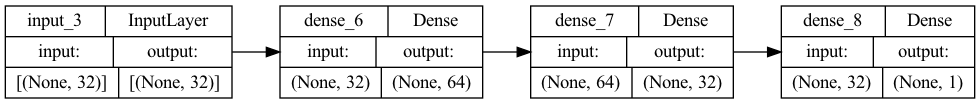

In [15]:
dict_inputs = feature_space.get_inputs()
encoded_features = feature_space.get_encoded_features()

# Build the model
x = keras.layers.Dense(64, activation='relu')(encoded_features)
x = keras.layers.Dense(32, activation='relu')(x)
predictions = keras.layers.Dense(1, activation='sigmoid')(x)

# this expects features that are already transformed
training_model = keras.Model(inputs=encoded_features, outputs=predictions)
training_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# this expects features that are not transformed
inference_model = keras.Model(inputs=dict_inputs, outputs=predictions)
inference_model.compile(loss='binary_crossentropy', metrics=['accuracy'])

inference_model.summary()

plot_model(training_model, show_shapes=True, show_layer_names=True, to_file='model.png',
           rankdir='LR', expand_nested=False, dpi=96)